In [1]:
import copy
from typing import Sequence

import numpy as np
import sympy as smp
import matplotlib.pyplot as plt

import optical_bloch
from optical_bloch.utils.general import flatten
from optical_bloch.utils.setup import hamiltonian_setup
from optical_bloch import (
    Hamiltonian,
    Dissipator,
    BlochEquations,
    generate_code,
    generate_lindblad_function_julia,
)

from optical_bloch.julia_utils import (
    OdeParameters,
    init_julia,
    OBEProblem,
    OBEProblemConfig,
    setup_solve_problem,
)

plt.rcParams.update({"font.size": 14})


c:\Users\ogras\anaconda3\envs\optical-bloch-python\Lib\site-packages\juliacall\__init__.py:237: UserWarning: Julia was started with multiple threads but multithreading support is experimental in JuliaCall. It is recommended to restart Python with the environment variable PYTHON_JULIACALL_HANDLE_SIGNALS=yes set, otherwise you may experience segfaults or other crashes. Note however that this interferes with Python's own signal handling, so for example Ctrl-C will not raise KeyboardInterrupt. See https://juliapy.github.io/PythonCall.jl/stable/faq/#Is-PythonCall/JuliaCall-thread-safe? for further information. You can suppress this warning by setting PYTHON_JULIACALL_HANDLE_SIGNALS=no.
  warnings.warn(


Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [2]:
# 4 ground states, 3 excited states (i.e. F=0, F=1 to F=1 excited)

ω = smp.Symbol("ω", real=True)
Ωz = smp.Symbol("Ωz", complex=True)
Ωx = smp.Symbol("Ωx", complex=True)
δ = smp.Symbol("δ", real=True)

ham = Hamiltonian(7)

# Z polarization
ham.add_manifold_coupling(
    [0, 1, 3],
    [5, 4, 6],
    Ωz,
    ω,
)

# X polarization
ham.add_manifold_coupling([0, 0, 1, 2, 2, 3], [4, 6, 5, 4, 6, 5], Ωx, ω)

display(ham.hamiltonian)

ham.eqn_transform()

display(ham.transformed)

ham.define_state_detuning(0, 5, δ)
ham.remove_common_energy()

display(ham.transformed)


Matrix([
[                              E0,                                0,                                0,                                0, -Ωx*exp(1.0*I*t*ω)/2, -Ωz*exp(1.0*I*t*ω)/2, -Ωx*exp(1.0*I*t*ω)/2],
[                               0,                               E1,                                0,                                0, -Ωz*exp(1.0*I*t*ω)/2, -Ωx*exp(1.0*I*t*ω)/2,                    0],
[                               0,                                0,                               E2,                                0, -Ωx*exp(1.0*I*t*ω)/2,                    0, -Ωx*exp(1.0*I*t*ω)/2],
[                               0,                                0,                                0,                               E3,                    0, -Ωx*exp(1.0*I*t*ω)/2, -Ωz*exp(1.0*I*t*ω)/2],
[-exp(-1.0*I*t*ω)*conjugate(Ωx)/2, -exp(-1.0*I*t*ω)*conjugate(Ωz)/2, -exp(-1.0*I*t*ω)*conjugate(Ωx)/2,                                0,                   E4,                 

Matrix([
[          E0 + ω,                0,                0,                0, -Ωx/2, -Ωz/2, -Ωx/2],
[               0,           E1 + ω,                0,                0, -Ωz/2, -Ωx/2,     0],
[               0,                0,           E2 + ω,                0, -Ωx/2,     0, -Ωx/2],
[               0,                0,                0,           E3 + ω,     0, -Ωx/2, -Ωz/2],
[-conjugate(Ωx)/2, -conjugate(Ωz)/2, -conjugate(Ωx)/2,                0,    E4,     0,     0],
[-conjugate(Ωz)/2, -conjugate(Ωx)/2,                0, -conjugate(Ωx)/2,     0,    E5,     0],
[-conjugate(Ωx)/2,                0, -conjugate(Ωx)/2, -conjugate(Ωz)/2,     0,     0,    E6]])

Matrix([
[              -δ,                0,                0,                0,   -Ωx/2, -Ωz/2,    -Ωx/2],
[               0,     -E0 + E1 - δ,                0,                0,   -Ωz/2, -Ωx/2,        0],
[               0,                0,     -E0 + E2 - δ,                0,   -Ωx/2,     0,    -Ωx/2],
[               0,                0,                0,     -E0 + E3 - δ,       0, -Ωx/2,    -Ωz/2],
[-conjugate(Ωx)/2, -conjugate(Ωz)/2, -conjugate(Ωx)/2,                0, E4 - E5,     0,        0],
[-conjugate(Ωz)/2, -conjugate(Ωx)/2,                0, -conjugate(Ωx)/2,       0,     0,        0],
[-conjugate(Ωx)/2,                0, -conjugate(Ωx)/2, -conjugate(Ωz)/2,       0,     0, -E5 + E6]])

In [3]:
Γ = smp.Symbol("Γ", real=True)
dis = Dissipator(ham.levels)

for idi, idf in zip([4, 4, 4, 5, 5, 5, 6, 6, 6], [0, 1, 2, 0, 1, 3, 0, 2, 3]):
    dis.add_decay(idi, idf, Γ)

display(dis.dissipator)


Matrix([
[Γ*(ρ44(t) + ρ55(t) + ρ66(t)),                        0,                        0,                        0,          -3*Γ*ρ04(t)/2,          -3*Γ*ρ05(t)/2, -3*Γ*ρ06(t)/2],
[                           0,      Γ*(ρ44(t) + ρ55(t)),                        0,                        0,          -3*Γ*ρ14(t)/2,          -3*Γ*ρ15(t)/2, -3*Γ*ρ16(t)/2],
[                           0,                        0,      Γ*(ρ44(t) + ρ66(t)),                        0,          -3*Γ*ρ24(t)/2,          -3*Γ*ρ25(t)/2, -3*Γ*ρ26(t)/2],
[                           0,                        0,                        0,      Γ*(ρ55(t) + ρ66(t)),          -3*Γ*ρ34(t)/2,          -3*Γ*ρ35(t)/2, -3*Γ*ρ36(t)/2],
[    -3*Γ*conjugate(ρ04(t))/2, -3*Γ*conjugate(ρ14(t))/2, -3*Γ*conjugate(ρ24(t))/2, -3*Γ*conjugate(ρ34(t))/2,            -3*Γ*ρ44(t),            -3*Γ*ρ45(t),   -3*Γ*ρ46(t)],
[    -3*Γ*conjugate(ρ05(t))/2, -3*Γ*conjugate(ρ15(t))/2, -3*Γ*conjugate(ρ25(t))/2, -3*Γ*conjugate(ρ35(t))/2, -3*Γ*conjugate(ρ4

In [4]:
E0, E1, E2, E3, E4, E5, E6 = ham.energies
replacements = [(E2, E1), (E3, E1), (E4, E2), (E5, E2), (E6, E2)]
transformed = ham.transformed.copy()
transformed = transformed.subs(replacements)


In [5]:
display(transformed)

Matrix([
[              -δ,                0,                0,                0, -Ωx/2, -Ωz/2, -Ωx/2],
[               0,     -E0 + E1 - δ,                0,                0, -Ωz/2, -Ωx/2,     0],
[               0,                0,     -E0 + E1 - δ,                0, -Ωx/2,     0, -Ωx/2],
[               0,                0,                0,     -E0 + E1 - δ,     0, -Ωx/2, -Ωz/2],
[-conjugate(Ωx)/2, -conjugate(Ωz)/2, -conjugate(Ωx)/2,                0,     0,     0,     0],
[-conjugate(Ωz)/2, -conjugate(Ωx)/2,                0, -conjugate(Ωx)/2,     0,     0,     0],
[-conjugate(Ωx)/2,                0, -conjugate(Ωx)/2, -conjugate(Ωz)/2,     0,     0,     0]])

In [6]:
bloch = BlochEquations(ham.levels, dis.density_matrix, transformed, dis.dissipator)

In [7]:
replacements = [
    (Ωx, "Ω0*resonant_switching(t, ωpol, 0.0)"),
    (Ωz, "Ω0*resonant_switching(t, ωpol, 3.1415)"),
    (E0, 0),
    (E1, 0.1),
]

code, free_parameters, compound_parameters, fixed_parameters = (
    generate_lindblad_function_julia(
        bloch.equations.rhs, bloch.density_matrix, replacements
    )
)


In [8]:
print(code)

function lindblad!(du, u, p, t)
    	@inbounds begin
    		Γ = p[1]
		Ω0 = p[2]
		δ = p[3]
		ωpol = p[4]
		E0 = 0
		E1 = 0.1
		Ωx = Ω0*resonant_switching(t, ωpol, 0.0)
		Ωz = Ω0*resonant_switching(t, ωpol, 3.1415)
		du[1,1] = Γ*(u[5,5] + u[6,6] + u[7,7]) + 1.0im*(Ωx*conj(u[1,5]) + Ωx*conj(u[1,7]) + Ωz*conj(u[1,6]) - u[1,5]*conj(Ωx) - u[1,6]*conj(Ωz) - u[1,7]*conj(Ωx))/2
		du[1,2] = 1.0im*(-E0*u[1,2] + E1*u[1,2] + Ωx*conj(u[2,5])/2 + Ωx*conj(u[2,7])/2 + Ωz*conj(u[2,6])/2 - u[1,5]*conj(Ωz)/2 - u[1,6]*conj(Ωx)/2)
		du[1,3] = 1.0im*(-E0*u[1,3] + E1*u[1,3] + Ωx*conj(u[3,5])/2 + Ωx*conj(u[3,7])/2 + Ωz*conj(u[3,6])/2 - u[1,5]*conj(Ωx)/2 - u[1,7]*conj(Ωx)/2)
		du[1,4] = 1.0im*(-E0*u[1,4] + E1*u[1,4] + Ωx*conj(u[4,5])/2 + Ωx*conj(u[4,7])/2 + Ωz*conj(u[4,6])/2 - u[1,6]*conj(Ωx)/2 - u[1,7]*conj(Ωz)/2)
		du[1,5] = -3*Γ*u[1,5]/2 + 1.0im*(-Ωx*u[1,1] - Ωx*u[1,3] + Ωx*u[5,5] + Ωx*conj(u[5,7]) - Ωz*u[1,2] + Ωz*conj(u[5,6]) + 2*δ*u[1,5])/2
		du[1,6] = -3*Γ*u[1,6]/2 + 1.0im*(-Ωx*u[1,2] - Ωx*u[1,4] + Ωx*u

In [51]:
odepars = OdeParameters(free_parameters, compound_parameters, fixed_parameters)
odepars

odepars.Ω0 = 1.0
odepars.Γ = 1.0
odepars.δ = 0.0
odepars.ωpol = 1.0


In [52]:
odepars

OdeParameters(Γ=1.0, Ω0=1.0, δ=0.0, ωpol=1.0)

In [53]:
odepars.parameter_values

{Ωx: Ω0*resonant_switching(t, ωpol, 0.0),
 Ωz: Ω0*resonant_switching(t, ωpol, 3.1415),
 E0: 0,
 E1: 0.1,
 Γ: 1.0,
 Ω0: 1.0,
 δ: 0.0,
 ωpol: 1.0}

In [54]:
from juliacall import Main as jl

init_julia(code)


In [55]:
jl.seval("""
function resonant_switching(t::Float64, ω::Float64, phase::Float64)::Float64
    -cos(pi*(1 .+ cos(ω .* t .+ phase))/2)/2 + 1/2
end
""")


resonant_switching (generic function with 1 method)

In [57]:
ρ = np.zeros(transformed.shape, dtype=complex)
for idx in range(4):
    ρ[idx, idx] = 1 / 4

problem = OBEProblem(odepars, ρ, (0, 150))
config = OBEProblemConfig(save_everystep=True)


In [56]:
sol = setup_solve_problem(problem, config)

15.55


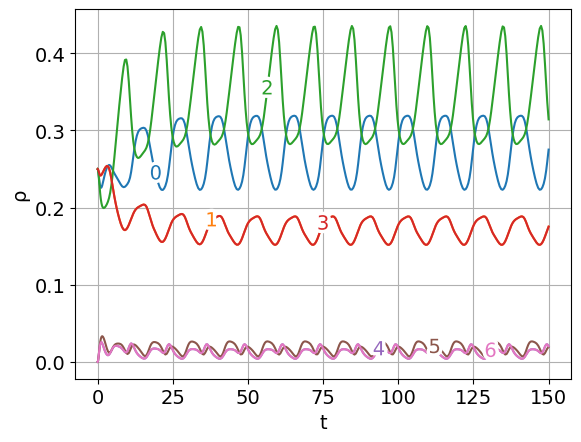

In [58]:
from labellines import labelLines

t = sol.t
y = np.einsum("ijj -> ij", sol.y).real

fig, ax = plt.subplots()
ax.plot(t, y, label=np.arange(ham.levels))

ax.set_xlabel("t")
ax.set_ylabel("ρ")

labelLines(ax.get_lines(), align=False, fontsize=14)

ax.grid()

print(f"{np.trapezoid(y[:, -3:].sum(axis=1)):.2f}")


In [36]:
ti = np.linspace(0, 100, 101)

resx = odepars.time_evolution_parameter("Ωx", ti)
resz = odepars.time_evolution_parameter("Ωz", ti)


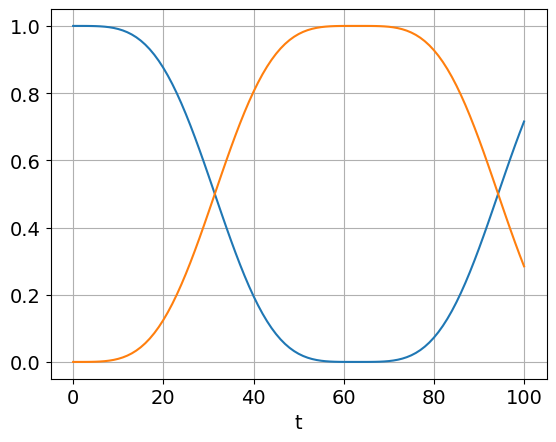

In [37]:
fig, ax = plt.subplots()
ax.plot(ti, resx)
ax.plot(ti, resz)

ax.set_xlabel("t")

ax.grid()
